# Method 3 - Best Ideas DGTW Select

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

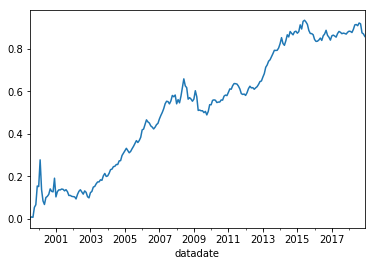

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.153576
2000-12-31    0.031976
2001-12-31   -0.072063
2002-12-31   -0.006410
2003-12-31    0.092131
2004-12-31    0.091696
2005-12-31    0.057263
2006-12-31    0.047544
2007-12-31    0.092278
2008-12-31   -0.018530
2009-12-31   -0.010548
2010-12-31    0.027916
2011-12-31    0.004690
2012-12-31    0.038809
2013-12-31    0.094617
2014-12-31    0.043718
2015-12-31   -0.008795
2016-12-31   -0.013630
2017-12-31    0.020178
2018-12-31   -0.010675
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     18.52
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.35e-13
Time:                        13:18:04   Log-Likelihood:                 654.05
No. Observations:                 234   AIC:                            -1298.
Df Residuals:                     229   BIC:                            -1281.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.603      0.110      -0.000       0.004
mktrf          0.0104      0.028      0.373      0.709      -0.045       0.065
me             0.2640      0.032      8.142      0.000       0.200       0.328
ia            -0.1367      0.049     -2.773      0.006      -0.234      -0.040
roe            0.1010      0.042      2.393      0.018       0.018       0.184
==============================================================================
Omnibus:                       77.283   Durbin-Watson:                   2.332
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1051.947
Skew:                          -0.848   Prob(JB):                    3.74e-229
Kurtosis:                      13.248   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     4.724
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00111
Time:                        13:18:04   Log-Likelihood:                 654.05
No. Observations:                 234   AIC:                            -1298.
Df Residuals:                     229   BIC:                            -1281.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.573      0.116      -0.000       0.004
mktrf          0.0104      0.048      0.219      0.827      -0.083       0.104
me             0.2640      0.093      2.833      0.005       0.081       0.447
ia            -0.1367      0.128     -1.069      0.285      -0.387       0.114
roe            0.1010      0.082      1.230      0.219      -0.060       0.262
==============================================================================
Omnibus:                       77.283   Durbin-Watson:                   2.332
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1051.947
Skew:                          -0.848   Prob(JB):                    3.74e-229
Kurtosis:                      13.248   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     3.774
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00541
Time:                        13:18:04   Log-Likelihood:                 654.05
No. Observations:                 234   AIC:                            -1298.
Df Residuals:                     229   BIC:                            -1281.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.450      0.147      -0.001       0.004
mktrf          0.0104      0.034      0.303      0.762      -0.057       0.078
me             0.2640      0.099      2.664      0.008       0.070       0.458
ia            -0.1367      0.114     -1.196      0.232      -0.361       0.087
roe            0.1010      0.068      1.475      0.140      -0.033       0.235
==============================================================================
Omnibus:                       77.283   Durbin-Watson:                   2.332
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1051.947
Skew:                          -0.848   Prob(JB):                    3.74e-229
Kurtosis:                      13.248   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     16.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.69e-14
Time:                        13:18:04   Log-Likelihood:                 658.03
No. Observations:                 234   AIC:                            -1304.
Df Residuals:                     228   BIC:                            -1283.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.390      0.018       0.000       0.004
mktrf         -0.0143      0.028     -0.521      0.603      -0.069       0.040
smb            0.1867      0.036      5.142      0.000       0.115       0.258
hml           -0.1761      0.043     -4.113      0.000      -0.260      -0.092
rmw           -0.0734      0.048     -1.516      0.131      -0.169       0.022
cma            0.1688      0.062      2.742      0.007       0.048       0.290
==============================================================================
Omnibus:                       62.502   Durbin-Watson:                   2.418
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              766.729
Skew:                          -0.604   Prob(JB):                    3.21e-167
Kurtosis:                      11.785   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     3.055
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0109
Time:                        13:18:04   Log-Likelihood:                 658.03
No. Observations:                 234   AIC:                            -1304.
Df Residuals:                     228   BIC:                            -1283.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.524      0.012       0.001       0.004
mktrf         -0.0143      0.033     -0.432      0.666      -0.079       0.051
smb            0.1867      0.066      2.850      0.004       0.058       0.315
hml           -0.1761      0.056     -3.143      0.002      -0.286      -0.066
rmw           -0.0734      0.082     -0.899      0.369      -0.234       0.087
cma            0.1688      0.149      1.129      0.259      -0.124       0.462
==============================================================================
Omnibus:                       62.502   Durbin-Watson:                   2.418
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              766.729
Skew:                          -0.604   Prob(JB):                    3.21e-167
Kurtosis:                      11.785   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     3.241
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00757
Time:                        13:18:04   Log-Likelihood:                 658.03
No. Observations:                 234   AIC:                            -1304.
Df Residuals:                     228   BIC:                            -1283.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.342      0.019       0.000       0.004
mktrf         -0.0143      0.026     -0.543      0.587      -0.066       0.037
smb            0.1867      0.056      3.313      0.001       0.076       0.297
hml           -0.1761      0.062     -2.841      0.004      -0.298      -0.055
rmw           -0.0734      0.076     -0.967      0.334      -0.222       0.075
cma            0.1688      0.164      1.029      0.304      -0.153       0.490
==============================================================================
Omnibus:                       62.502   Durbin-Watson:                   2.418
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              766.729
Skew:                          -0.604   Prob(JB):                    3.21e-167
Kurtosis:                      11.785   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     63.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.45e-36
Time:                        13:18:04   Log-Likelihood:                 708.25
No. Observations:                 234   AIC:                            -1407.
Df Residuals:                     229   BIC:                            -1389.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.526      0.129      -0.000       0.003
mktrf          0.0844      0.020      4.145      0.000       0.044       0.125
smb            0.1484      0.025      5.840      0.000       0.098       0.198
hml           -0.0422      0.025     -1.670      0.096      -0.092       0.008
umd            0.1942      0.017     11.723      0.000       0.162       0.227
==============================================================================
Omnibus:                       78.026   Durbin-Watson:                   2.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              729.754
Skew:                          -0.997   Prob(JB):                    3.43e-159
Kurtosis:                      11.418   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     12.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.74e-09
Time:                        13:18:04   Log-Likelihood:                 708.25
No. Observations:                 234   AIC:                            -1407.
Df Residuals:                     229   BIC:                            -1389.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.541      0.123      -0.000       0.003
mktrf          0.0844      0.030      2.809      0.005       0.026       0.143
smb            0.1484      0.062      2.402      0.016       0.027       0.269
hml           -0.0422      0.050     -0.839      0.401      -0.141       0.056
umd            0.1942      0.035      5.566      0.000       0.126       0.263
==============================================================================
Omnibus:                       78.026   Durbin-Watson:                   2.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              729.754
Skew:                          -0.997   Prob(JB):                    3.43e-159
Kurtosis:                      11.418   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     12.89
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.76e-09
Time:                        13:18:04   Log-Likelihood:                 708.25
No. Observations:                 234   AIC:                            -1407.
Df Residuals:                     229   BIC:                            -1389.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.388      0.165      -0.000       0.003
mktrf          0.0844      0.023      3.615      0.000       0.039       0.130
smb            0.1484      0.050      2.972      0.003       0.051       0.246
hml           -0.0422      0.045     -0.944      0.345      -0.130       0.045
umd            0.1942      0.038      5.070      0.000       0.119       0.269
==============================================================================
Omnibus:                       78.026   Durbin-Watson:                   2.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              729.754
Skew:                          -0.997   Prob(JB):                    3.43e-159
Kurtosis:                      11.418   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     12.03
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.34e-08
Time:                        13:18:05   Log-Likelihood:                 306.33
No. Observations:                 120   AIC:                            -602.7
Df Residuals:                     115   BIC:                            -588.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.572      0.568      -0.003       0.005
mktrf          0.0382      0.050      0.771      0.443      -0.060       0.136
me             0.3279      0.049      6.691      0.000       0.231       0.425
ia            -0.1509      0.077     -1.966      0.052      -0.303       0.001
roe            0.1803      0.068      2.654      0.009       0.046       0.315
==============================================================================
Omnibus:                       31.323   Durbin-Watson:                   2.384
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.291
Skew:                          -0.697   Prob(JB):                     3.13e-34
Kurtosis:                       8.377   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     5.810
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000270
Time:                        13:18:05   Log-Likelihood:                 306.33
No. Observations:                 120   AIC:                            -602.7
Df Residuals:                     115   BIC:                            -588.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.568      0.570      -0.003       0.005
mktrf          0.0382      0.080      0.477      0.634      -0.119       0.195
me             0.3279      0.110      2.979      0.003       0.112       0.544
ia            -0.1509      0.162     -0.933      0.351      -0.468       0.166
roe            0.1803      0.105      1.724      0.085      -0.025       0.385
==============================================================================
Omnibus:                       31.323   Durbin-Watson:                   2.384
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.291
Skew:                          -0.697   Prob(JB):                     3.13e-34
Kurtosis:                       8.377   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     5.031
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000899
Time:                        13:18:05   Log-Likelihood:                 306.33
No. Observations:                 120   AIC:                            -602.7
Df Residuals:                     115   BIC:                            -588.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.518      0.604      -0.003       0.005
mktrf          0.0382      0.057      0.668      0.504      -0.074       0.150
me             0.3279      0.118      2.767      0.006       0.096       0.560
ia            -0.1509      0.151     -0.996      0.319      -0.448       0.146
roe            0.1803      0.078      2.310      0.021       0.027       0.333
==============================================================================
Omnibus:                       31.323   Durbin-Watson:                   2.384
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.291
Skew:                          -0.697   Prob(JB):                     3.13e-34
Kurtosis:                       8.377   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     9.412
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.57e-07
Time:                        13:18:05   Log-Likelihood:                 306.08
No. Observations:                 120   AIC:                            -600.2
Df Residuals:                     114   BIC:                            -583.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.388      0.168      -0.001       0.006
mktrf         -0.0299      0.053     -0.568      0.571      -0.134       0.074
smb            0.2164      0.060      3.629      0.000       0.098       0.335
hml           -0.1935      0.073     -2.648      0.009      -0.338      -0.049
rmw           -0.0622      0.086     -0.722      0.472      -0.233       0.108
cma            0.2046      0.094      2.167      0.032       0.018       0.392
==============================================================================
Omnibus:                       24.789   Durbin-Watson:                   2.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.830
Skew:                          -0.500   Prob(JB):                     5.20e-25
Kurtosis:                       7.622   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     2.898
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0168
Time:                        13:18:05   Log-Likelihood:                 306.08
No. Observations:                 120   AIC:                            -600.2
Df Residuals:                     114   BIC:                            -583.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.572      0.116      -0.001       0.006
mktrf         -0.0299      0.059     -0.507      0.612      -0.146       0.086
smb            0.2164      0.088      2.460      0.014       0.044       0.389
hml           -0.1935      0.075     -2.585      0.010      -0.340      -0.047
rmw           -0.0622      0.106     -0.586      0.558      -0.270       0.146
cma            0.2046      0.186      1.098      0.272      -0.161       0.570
==============================================================================
Omnibus:                       24.789   Durbin-Watson:                   2.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.830
Skew:                          -0.500   Prob(JB):                     5.20e-25
Kurtosis:                       7.622   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     3.356
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00727
Time:                        13:18:05   Log-Likelihood:                 306.08
No. Observations:                 120   AIC:                            -600.2
Df Residuals:                     114   BIC:                            -583.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.455      0.146      -0.001       0.006
mktrf         -0.0299      0.049     -0.614      0.539      -0.125       0.066
smb            0.2164      0.073      2.963      0.003       0.073       0.360
hml           -0.1935      0.083     -2.326      0.020      -0.357      -0.030
rmw           -0.0622      0.102     -0.612      0.540      -0.262       0.137
cma            0.2046      0.197      1.036      0.300      -0.182       0.591
==============================================================================
Omnibus:                       24.789   Durbin-Watson:                   2.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.830
Skew:                          -0.500   Prob(JB):                     5.20e-25
Kurtosis:                       7.622   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     42.56
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.31e-22
Time:                        13:18:05   Log-Likelihood:                 339.85
No. Observations:                 120   AIC:                            -669.7
Df Residuals:                     115   BIC:                            -655.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.442      0.152      -0.001       0.005
mktrf          0.1165      0.033      3.526      0.001       0.051       0.182
smb            0.1412      0.038      3.753      0.000       0.067       0.216
hml           -0.0469      0.038     -1.243      0.216      -0.122       0.028
umd            0.2289      0.023      9.849      0.000       0.183       0.275
==============================================================================
Omnibus:                       47.497   Durbin-Watson:                   2.400
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.658
Skew:                          -1.231   Prob(JB):                     4.97e-51
Kurtosis:                       9.346   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     18.25
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.25e-11
Time:                        13:18:05   Log-Likelihood:                 339.85
No. Observations:                 120   AIC:                            -669.7
Df Residuals:                     115   BIC:                            -655.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.468      0.142      -0.001       0.005
mktrf          0.1165      0.047      2.454      0.014       0.023       0.210
smb            0.1412      0.074      1.898      0.058      -0.005       0.287
hml           -0.0469      0.060     -0.783      0.433      -0.164       0.070
umd            0.2289      0.037      6.198      0.000       0.156       0.301
==============================================================================
Omnibus:                       47.497   Durbin-Watson:                   2.400
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.658
Skew:                          -1.231   Prob(JB):                     4.97e-51
Kurtosis:                       9.346   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     28.22
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.46e-16
Time:                        13:18:05   Log-Likelihood:                 339.85
No. Observations:                 120   AIC:                            -669.7
Df Residuals:                     115   BIC:                            -655.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.409      0.159      -0.001       0.005
mktrf          0.1165      0.032      3.655      0.000       0.054       0.179
smb            0.1412      0.058      2.416      0.016       0.027       0.256
hml           -0.0469      0.057     -0.827      0.408      -0.158       0.064
umd            0.2289      0.034      6.709      0.000       0.162       0.296
==============================================================================
Omnibus:                       47.497   Durbin-Watson:                   2.400
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.658
Skew:                          -1.231   Prob(JB):                     4.97e-51
Kurtosis:                       9.346   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     9.975
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.46e-07
Time:                        13:18:05   Log-Likelihood:                 408.10
No. Observations:                 114   AIC:                            -806.2
Df Residuals:                     109   BIC:                            -792.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.545      0.012       0.000       0.003
mktrf          0.0330      0.020      1.628      0.106      -0.007       0.073
me             0.0681      0.031      2.175      0.032       0.006       0.130
ia            -0.1470      0.043     -3.383      0.001      -0.233      -0.061
roe           -0.0960      0.038     -2.516      0.013      -0.172      -0.020
==============================================================================
Omnibus:                        0.472   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.266
Skew:                           0.114   Prob(JB):                        0.876
Kurtosis:                       3.061   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     10.68
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.43e-07
Time:                        13:18:05   Log-Likelihood:                 408.10
No. Observations:                 114   AIC:                            -806.2
Df Residuals:                     109   BIC:                            -792.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.381      0.017       0.000       0.003
mktrf          0.0330      0.017      1.965      0.049    7.68e-05       0.066
me             0.0681      0.040      1.718      0.086      -0.010       0.146
ia            -0.1470      0.054     -2.709      0.007      -0.253      -0.041
roe           -0.0960      0.046     -2.085      0.037      -0.186      -0.006
==============================================================================
Omnibus:                        0.472   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.266
Skew:                           0.114   Prob(JB):                        0.876
Kurtosis:                       3.061   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     14.46
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-09
Time:                        13:18:05   Log-Likelihood:                 408.10
No. Observations:                 114   AIC:                            -806.2
Df Residuals:                     109   BIC:                            -792.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.954      0.051   -5.34e-06       0.004
mktrf          0.0330      0.015      2.229      0.026       0.004       0.062
me             0.0681      0.040      1.718      0.086      -0.010       0.146
ia            -0.1470      0.054     -2.705      0.007      -0.253      -0.040
roe           -0.0960      0.040     -2.387      0.017      -0.175      -0.017
==============================================================================
Omnibus:                        0.472   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.266
Skew:                           0.114   Prob(JB):                        0.876
Kurtosis:                       3.061   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     10.49
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.16e-08
Time:                        13:18:05   Log-Likelihood:                 412.89
No. Observations:                 114   AIC:                            -813.8
Df Residuals:                     108   BIC:                            -797.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.296      0.024       0.000       0.003
mktrf          0.0424      0.019      2.274      0.025       0.005       0.079
smb            0.0741      0.030      2.448      0.016       0.014       0.134
hml           -0.1073      0.039     -2.781      0.006      -0.184      -0.031
rmw           -0.1507      0.047     -3.190      0.002      -0.244      -0.057
cma           -0.0307      0.060     -0.512      0.609      -0.150       0.088
==============================================================================
Omnibus:                        6.255   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                8.285
Skew:                          -0.245   Prob(JB):                       0.0159
Kurtosis:                       4.226   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     9.191
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.60e-07
Time:                        13:18:05   Log-Likelihood:                 412.89
No. Observations:                 114   AIC:                            -813.8
Df Residuals:                     108   BIC:                            -797.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.147      0.032       0.000       0.003
mktrf          0.0424      0.020      2.082      0.037       0.002       0.082
smb            0.0741      0.032      2.348      0.019       0.012       0.136
hml           -0.1073      0.032     -3.381      0.001      -0.170      -0.045
rmw           -0.1507      0.032     -4.727      0.000      -0.213      -0.088
cma           -0.0307      0.064     -0.478      0.632      -0.157       0.095
==============================================================================
Omnibus:                        6.255   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                8.285
Skew:                          -0.245   Prob(JB):                       0.0159
Kurtosis:                       4.226   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     9.220
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.48e-07
Time:                        13:18:05   Log-Likelihood:                 412.89
No. Observations:                 114   AIC:                            -813.8
Df Residuals:                     108   BIC:                            -797.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.822      0.069      -0.000       0.003
mktrf          0.0424      0.021      1.998      0.046       0.001       0.084
smb            0.0741      0.030      2.469      0.014       0.015       0.133
hml           -0.1073      0.031     -3.435      0.001      -0.169      -0.046
rmw           -0.1507      0.033     -4.609      0.000      -0.215      -0.087
cma           -0.0307      0.062     -0.493      0.622      -0.153       0.091
==============================================================================
Omnibus:                        6.255   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                8.285
Skew:                          -0.245   Prob(JB):                       0.0159
Kurtosis:                       4.226   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     11.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-07
Time:                        13:18:05   Log-Likelihood:                 409.91
No. Observations:                 114   AIC:                            -809.8
Df Residuals:                     109   BIC:                            -796.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.405      0.163      -0.000       0.002
mktrf          0.0624      0.019      3.300      0.001       0.025       0.100
smb            0.1008      0.029      3.415      0.001       0.042       0.159
hml           -0.0684      0.030     -2.253      0.026      -0.129      -0.008
umd            0.0530      0.023      2.314      0.023       0.008       0.098
==============================================================================
Omnibus:                        0.831   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.789
Skew:                          -0.199   Prob(JB):                        0.674
Kurtosis:                       2.909   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     9.948
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.70e-07
Time:                        13:18:05   Log-Likelihood:                 409.91
No. Observations:                 114   AIC:                            -809.8
Df Residuals:                     109   BIC:                            -796.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.311      0.190      -0.000       0.002
mktrf          0.0624      0.017      3.726      0.000       0.030       0.095
smb            0.1008      0.032      3.146      0.002       0.038       0.164
hml           -0.0684      0.032     -2.140      0.032      -0.131      -0.006
umd            0.0530      0.023      2.343      0.019       0.009       0.097
==============================================================================
Omnibus:                        0.831   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.789
Skew:                          -0.199   Prob(JB):                        0.674
Kurtosis:                       2.909   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     11.55
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.41e-08
Time:                        13:18:05   Log-Likelihood:                 409.91
No. Observations:                 114   AIC:                            -809.8
Df Residuals:                     109   BIC:                            -796.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.173      0.241      -0.001       0.003
mktrf          0.0624      0.015      4.070      0.000       0.032       0.093
smb            0.1008      0.033      3.061      0.002       0.036       0.165
hml           -0.0684      0.032     -2.127      0.033      -0.132      -0.005
umd            0.0530      0.023      2.277      0.023       0.007       0.099
==============================================================================
Omnibus:                        0.831   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.789
Skew:                          -0.199   Prob(JB):                        0.674
Kurtosis:                       2.909   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""